# Fitting a distribution to simulated TC winds

Once we have simulated the wind swaths from a catalogue of TC events, we now want to examine what the probability of occurrence is for any given event. 

TCRM stores the simulated wind speed from each event at each location in the input location file, in a SQLite3 database. We can run a query on the database, and get the complete list of all events that generate high winds at a location. From that, we can demonstrate how TCRM fits an extreme value distribution to each point, to determine the return level wind speeds. 



In [1]:
%matplotlib notebook
from __future__ import print_function, division
import os
import io
import sys

import database
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FormatStrFormatter
from ipywidgets import interact, fixed, Dropdown, interactive
import ipywidgets as widgets
from Utilities.config import ConfigParser

from scipy.stats import genpareto

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

We make use of some extra functions that are maintained in a separate module (I use these for working with observed wind speed data for validation of TCRM and other applications).

In [2]:
from extremes import returnLevels, empReturnPeriod, returnPeriodUncertainty, gpdSelectThreshold
from distributions import fittedPDF

Set up the configuration for the simulation. The key parts are to: 
 - set the `TrackGenerator--NumSimulations` value to match what was used in your full TCRM simulation
 - set the same `Output--Path` and 
 - set the same `Region--gridLimit` settings.
 
 

In [3]:
configstr = """
[DataProcess]
InputFile=/home/tcrm/data/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=False

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':175.,'xMax':185.,'yMin':-23.0,'yMax':-13.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=10000
YearsPerSimulation=1
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = /home/tcrm/tcrm/input/landmask.nc
mslpfile = /home/tcrm/tcrm/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=/media/sf_share/tcrm/fiji

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=/media/sf_share/tcrm/fiji/log/fiji.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r09.csv.gz
path = /home/tcrm//tcrm/input/
filename = Allstorms.ibtracs_wmo.v03r09.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = /home/tcrm//tcrm/MSLP
filename = slp.day.ltm.nc

[Process]
DatFile=/media/sf_share/tcrm/fiji/process/dat/fiji.dat
ExcludePastProcessed=False
"""

config = ConfigParser()
config.readfp(io.BytesIO(configstr))

In [4]:
configFile = "/g/data/w85/TCRM_data/tcrm2.1/tcrm2.1.201805310953.ini"
config = ConfigParser()
config.read(configFile)

In [5]:
outputPath = config.get('Output', 'Path')
print(outputPath)

/g/data/w85/TCRM_data/tcrm2.1


Here, we load the database, and get a list of locations that are stored in the database. This will be used to create a dropdown so you can select the locations and automatically plot the return level curve.

In [6]:
db = database.HazardDatabase(configFile)
locations = db.getLocations()
locNameList = list(locations['locName'])
outputPath = config.get('Output', 'Path')
NumSimulations = config.getint('TrackGenerator', 'NumSimulations')

Now we define a number of functions to perform the data extraction, fitting routine and plotting...

In [7]:
from scipy.optimize import curve_fit
from scipy.stats import scoreatpercentile
import lmfit

def residual(p, x, y):
    return genpareto.pdf(x, p['xi'], loc=p['mu'], scale=p['sig']) - y

def calcSD(pars, cov, rate, npyr, intervals):
    nsims = 1000
    rps = np.zeros((nsims, len(intervals)))
    for i in range(nsims):
        xi = pars[0] + np.random.normal(0, np.sqrt(cov[0,0]))
        mu = pars[1] + np.random.normal(0, np.sqrt(cov[1,1]))
        sig = pars[2] + np.random.normal(0, np.sqrt(cov[2,2]))
        rps[i, : ] = mu + (sig / xi) * (np.power(intervals * npyr * rate, xi) - 1.)

    lowerrp = scoreatpercentile(rps, 2.5, axis=0)
    upperrp = scoreatpercentile(rps, 97.5, axis=0)
    return lowerrp, upperrp

def calculateUncertainty(wspd, intervals, xi, mu, sig):
    """
    :param wspd: :class:`numpy.array` of wind speeds
    :param float xi: initial guess for 
    """
    bins = np.arange(0.5, 100, 1)
    n, bins = np.histogram(wspd, bins, normed=True)
    centres = 0.5*(bins[1:]+bins[:-1])
    #pars,cov = curve_fit(lambda x, xi, mu, sig: genpareto.pdf(x, xi, loc=mu, scale=sig), 
    #                     centres, n, p0=[0, np.mean(wspd), np.mean(wspd)], maxfev=10000 )
    gpd = genpareto.fit(wspd[wspd > mu], loc=mu)
    npyr = 365.25

    p = lmfit.Parameters()
    p.add_many(('xi', gpd[0], True, -np.inf, 1.), ('mu', gpd[1]),('sig', gpd[2]))

    mini = lmfit.Minimizer(residual, p, fcn_args=(centres, n), nan_policy='omit')

    # first solve with Nelder-Mead
    out1 = mini.minimize(method='Nelder')
    out2 = mini.minimize(method='leastsq', params=out1.params)

    cmu = out2.params['mu'].value
    cxi = out2.params['xi'].value
    csig = out2.params['sig'].value
    rate = len(wspd[wspd > cmu])/(npyr*10000)
    print("Rate (calcUncertainty): {0}".format(rate))
    crp = cmu + (csig / cxi) * (np.power(intervals * npyr * rate, cxi) - 1.)
    lrp, urp = calcSD((cxi, cmu, csig), out2.covar, rate, npyr, intervals)
    return crp, lrp, urp


In [8]:
class PlotUnits(object):

    def __init__(self, units):
        labels = {
            'mps': 'm/s',
            'mph': 'mi/h',
            'kts': 'kts',
            'kph': 'km/h',
            'kmh': 'km/h'
        }

        levels = {
            'mps': np.arange(30, 101., 5.),
            'mph': np.arange(80, 221., 10.),
            'kts': np.arange(60, 201., 10.),
            'kph': np.arange(80, 361., 20.),
            'kmh': np.arange(80, 361., 20.)
        }

        self.units = units
        self.label = labels[units]
        self.levels = levels[units]
        
# Set the plotting units to be metres/second
plotUnits = PlotUnits('mps')

def extractRecords(db, locId, nsimulations):
    recs = database.locationRecords(db, locId)
    data = np.zeros(int(nsimulations * 365.25))
    data[-len(recs):] = recs['wspd']

    allevents = np.sort(data)
    return allevents

def extractReturnLevel(db, locId):
    recs = database.locationAllReturnLevels(db, locId)
    return recs

def fitDistribution(db, locId, intervals, nyears):
    records = database.locationRecords(db, locId)
    recs = records['wspd'][records['wspd'] > 0]
    threshold = np.percentile(recs, 99.5)
    gpd = genpareto.fit(recs[recs > threshold], loc=threshold)
    print(gpd)
    data = np.zeros(int(nyears*365.25))
    data[-len(recs):] = recs
    rate = float(len(data[data > threshold])) / float(len(data))
    print("Rate (fitDistribution): {0}".format(rate))
    rval = returnLevels(intervals, threshold, gpd[0], gpd[2], rate)
    crp, lrp, urp = calculateUncertainty(recs, intervals, gpd[0], gpd[1], gpd[2])
    print(crp)
    return crp, lrp, urp

def addGrid(axes):
    """
    Add a logarithmic graticule to the subplot axes.
    :param axes: :class:`axes` instance.
    """

    axes.xaxis.set_major_locator(LogLocator())
    axes.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axes.xaxis.set_minor_locator(LogLocator(subs=[.1, .2, .3, .4, .5, .6, .7, .8, .9]))
    axes.autoscale(True, axis='x', tight=True)
    axes.grid(True, which='major', linestyle='-', linewidth=0.5)
    axes.grid(True, which='minor', linestyle='-', linewidth=0.5)
    
def subplot(axes, subfigure):
    """
    Draw a line and range plot on an :class:`matplotlib.axes`
    instance, with a logarithmic scale on the x-axis. Data and
    labels are contained in a tuple. x-ticks presented as integer
    values. A grid is added with a call to
    :meth:`SemilogCurve.addGrid`.
    :param axes: :class:`matplotlib.axes` instance.
    :param tuple subfigure: Holds the data and labels to be added
                            to the subplot.
    """
    xdata, events, ydata, xlabel, ylabel, title, fit = subfigure
    rp, lrp, urp = ydata
    emprp = empReturnPeriod(events)

    axes.semilogx(xdata, rp, lw=2, subsx=xdata, 
                  label = 'Fitted hazard curve ({0})'.format(fit))
    axes.scatter(emprp[emprp > 1], events[emprp > 1], s=100,
                 color='r', label = 'Empirical ARI')
    axes.semilogx(xdata, lrp, lw=2, color='0.5', linestyle='--', subsx=xdata)
    axes.semilogx(xdata, urp, lw=2, color='0.5', linestyle='--', subsx=xdata, label="90% CI")

    axes.legend(loc = 2)

    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    ylim = (0., np.max([100, np.ceil(rp.max()/10.)*10.]))
    axes.set_ylim(ylim)
    addGrid(axes)
    return axes
    
def plot(years, events, rlevel, locName, locLon, locLat, fit):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    xlabel = 'Average recurrence interval (years)'
    ylabel = 'Wind speed (%s)'%plotUnits.label
    title = "Return period wind speeds at " + locName + ", \n(%5.1f,%5.1f)"%(locLon, locLat)
    subfigure = (years, events, rlevel, xlabel, ylabel, title, fit)
    ax = subplot(ax, subfigure)
    fig.tight_layout()
    plt.show()
    
def plotLocation(locName):
    years = np.array(config.get('Hazard', 'Years').split(',')).astype(float)
    locId = locations['locId'][locations['locName']==locName][0]
    events = extractRecords(db, locId, NumSimulations)
    rlevel = fitDistribution(db, locId, years, NumSimulations)
    locLon = locations['locLon'][locations['locId']==locId][0]
    locLat = locations['locLat'][locations['locId']==locId][0]
    plot(years, events, rlevel, locName, locLon, locLat, 'GPD')
    

In [9]:
interactive(plotLocation, 
            locName=Dropdown(options=locNameList, description="Location"))

(-0.025672038369406368, 58.431507108596023, 5.0980134838886233)
Rate (fitDistribution): 1.56057494867e-05
Rate (calcUncertainty): 1.75222450376e-05


AttributeError: 'MinimizerResult' object has no attribute 'covar'

In [23]:
def processCI(locName, percentile=99.):
    locId = locations['locId'][locations['locName']==locName][0]
    recs = database.locationRecords(db, locId)
    wspd = recs['wspd'][recs['wspd']>0]
    print("Number of records > 0: {0}".format(len(wspd[wspd > 0])))
    data = np.zeros(365.25*10000)
    data[-len(wspd):] = wspd
    emprp = empReturnPeriod(data)
    threshold = np.percentile(wspd[wspd > 0], percentile)
    gpd = genpareto.fit(wspd[wspd > threshold], loc=threshold)

    print(threshold)
    print(gpd)
    print("No. exceedances: {0}".format(len(wspd[wspd > gpd[1]])))
    years = np.array(config.get('Hazard', 'Years').split(',')).astype(float)
    crp, lrp, urp = calculateUncertainty(wspd[wspd > threshold], years, *gpd)
    print(crp)
    fig, ax = plt.subplots(1, 1)
    ax.semilogx(years, crp, label="Fitted GPD")
    ax.semilogx(years, lrp, '0.5', linestyle='--', label="95% CI")
    ax.semilogx(years, urp, '0.5', linestyle='--')
    ax.scatter(emprp[emprp > 1], data[emprp > 1], s=100,
                     color='r', label = 'Empirical ARI')
    addGrid(ax)
    ax.set_ylim((0, 100))
    ax.set_title("{0}".format(locName))
    ax.set_xlabel("ARI (years)")
    ax.set_ylabel("Wind speed (m/s)")
    ax.legend(loc=2)
    fig.tight_layout()
    plt.savefig("{0}.png".format(locId), bbox_inches='tight')
    
    fmt = ['%d', '%.3f', '%.3f','%.3f']
    fmt_emp = ['%.1f', '%.3f']
    hdr = 'ARI,lower,mean,upper'
    hdr_emp = 'ARI,windspeed'
    fname = '{0:d}.csv'.format(locId)
    np.savetxt(fname, np.vstack([years, lrp, crp, urp]).T, fmt=fmt, delimiter=',', header=hdr)
    fname_emp = '{0:d}_empari.csv'.format(locId)
    np.savetxt(fname_emp, np.vstack([emprp[emprp > 1], data[emprp > 1]]).T, fmt=fmt_emp,
               delimiter=',', header=hdr_emp)
    

Number of records > 0: 19438
36.9401081085
(0.060720263232617144, 36.943199157661326, 4.7981150338604515)
No. exceedances: 195


/home/547/cxa547/venv/notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


Rate (calcUncertainty): 5.33880903491e-05
[  3.57001072  15.90710578  23.39216241  29.58778551  31.34567849
  36.17116764  40.16538085  43.47152012  44.40957573  46.98457729
  49.11598924  50.88022775  52.75488282  53.89225749]


<IPython.core.display.Javascript object>


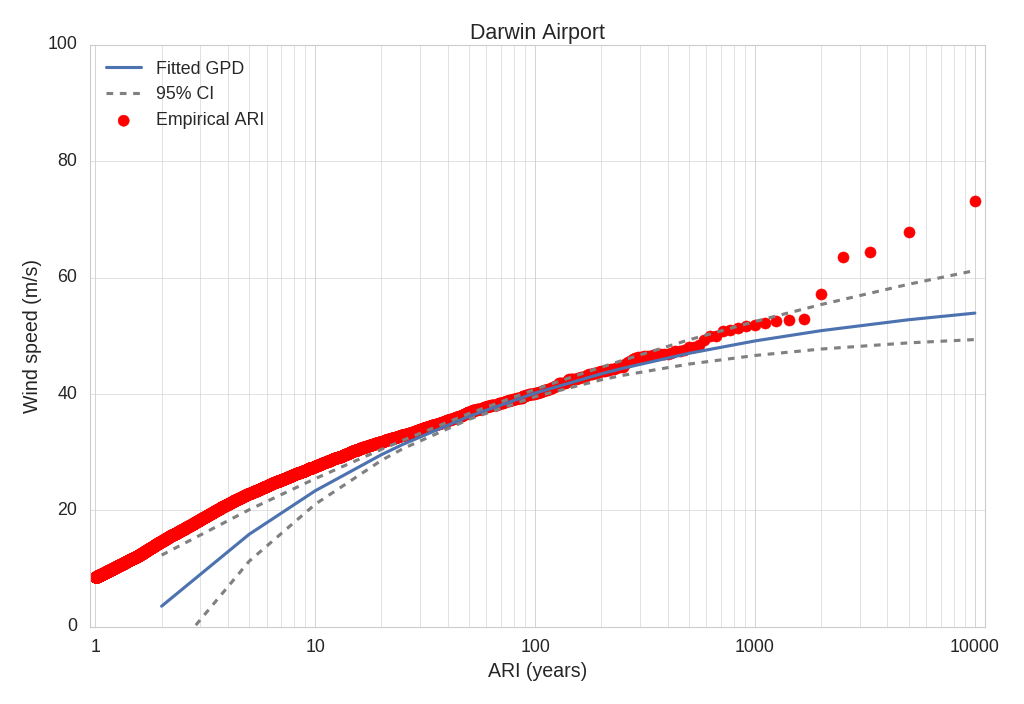

In [24]:
processCI("Darwin Airport")

Carnarvon Airport
Number of records > 0: 5913
44.9900601196
(-0.12823436962680929, 44.993888853628675, 6.2469280613637039)
No. exceedances: 60


/home/547/cxa547/venv/notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


Rate (calcUncertainty): 1.64271047228e-05
[-23.03731134  -1.14748675  11.9046517   22.54956729  25.53980564
  33.66997207  40.30068134  45.70848028  47.22757244  51.35783585
  54.72634941  57.47360364  60.34357277  62.0548352 ]


<IPython.core.display.Javascript object>


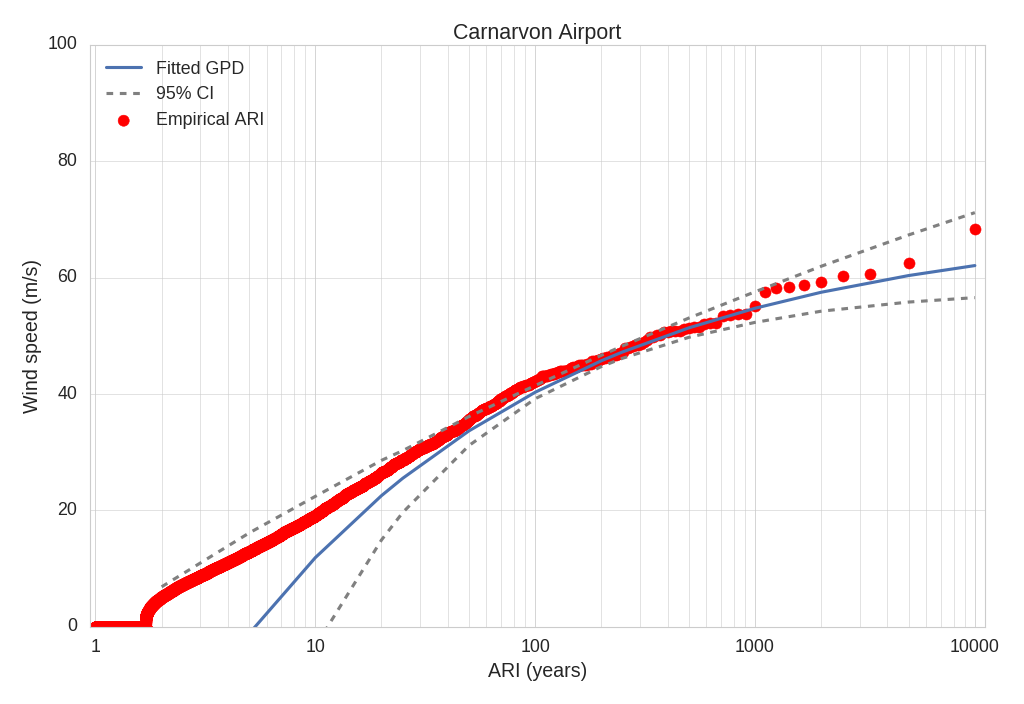

Learmonth Airport
Number of records > 0: 8603
50.8930474091
(-0.23749057934790863, 50.893093103678723, 6.8957862568325856)
No. exceedances: 87
Rate (calcUncertainty): 2.3819301848e-05
[-63.25056711 -14.98755137   9.25742668  26.35380858  30.70297392
  41.47616773  49.07290117  54.42974892  55.79248267  59.16807168
  61.54837324  63.22684638  64.7115157   65.45734093]


<IPython.core.display.Javascript object>


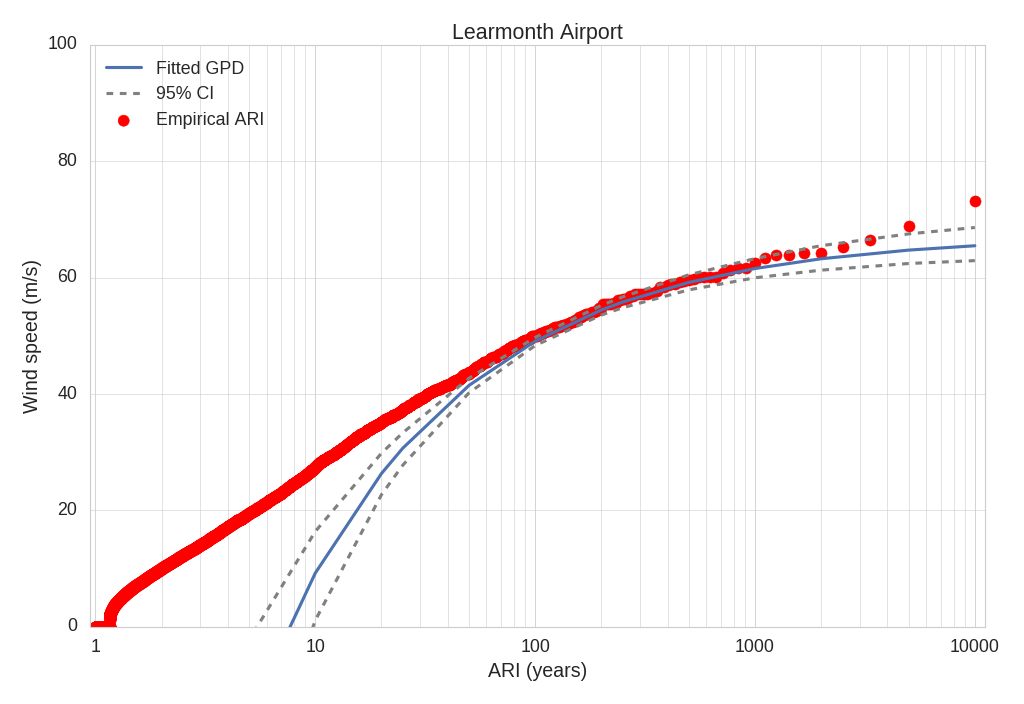

Onslow
Number of records > 0: 9706
54.2275791168
(-0.24321862615733714, 54.234752479365369, 8.4550392813412607)
No. exceedances: 98
Rate (calcUncertainty): 2.68309377139e-05
[-37.71077686  -3.3451357   15.8423375   30.63994321  34.64198964
  45.13845673  53.23345598  59.47641491  61.16483749  65.5931899
  69.00838753  71.64222823  74.22283322  75.66367026]


<IPython.core.display.Javascript object>


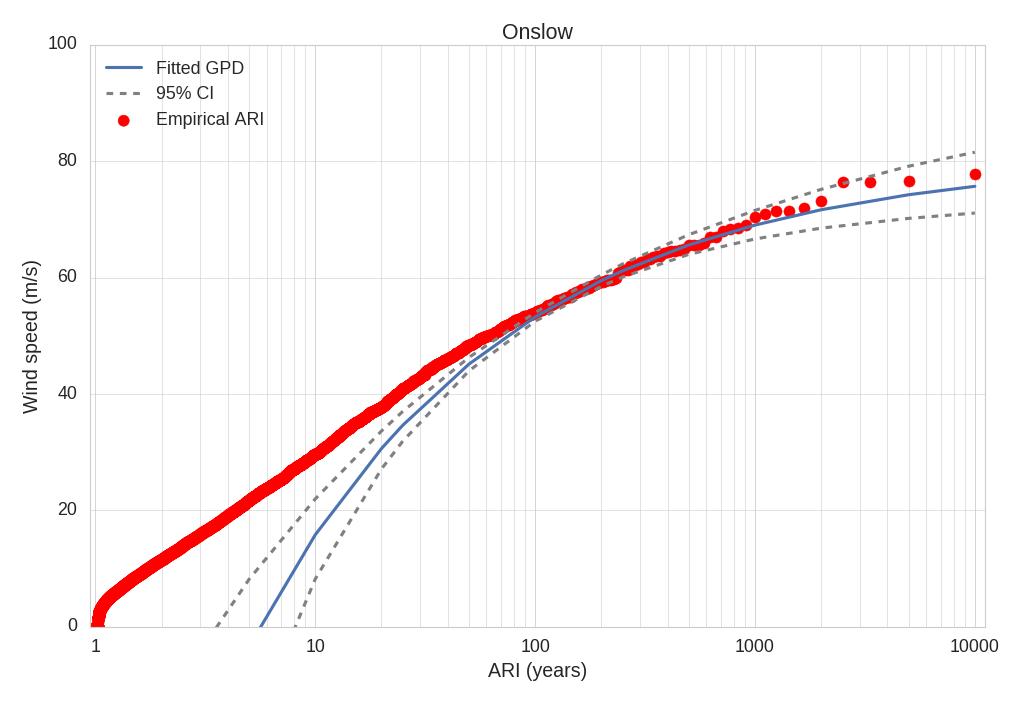

Port Hedland Airport
Number of records > 0: 12771
53.6771614075
(-0.00069045667159090365, 53.687484740700071, 6.5816156570857647)
No. exceedances: 128
Rate (calcUncertainty): 3.50444900753e-05
[  2.03099516  20.59316398  31.54254636  40.39094807  42.86114878
  49.53772344  54.93318892  59.29336599  60.51059288  63.80057097
  66.4592641   68.607804    70.828794    72.13890324]


<IPython.core.display.Javascript object>


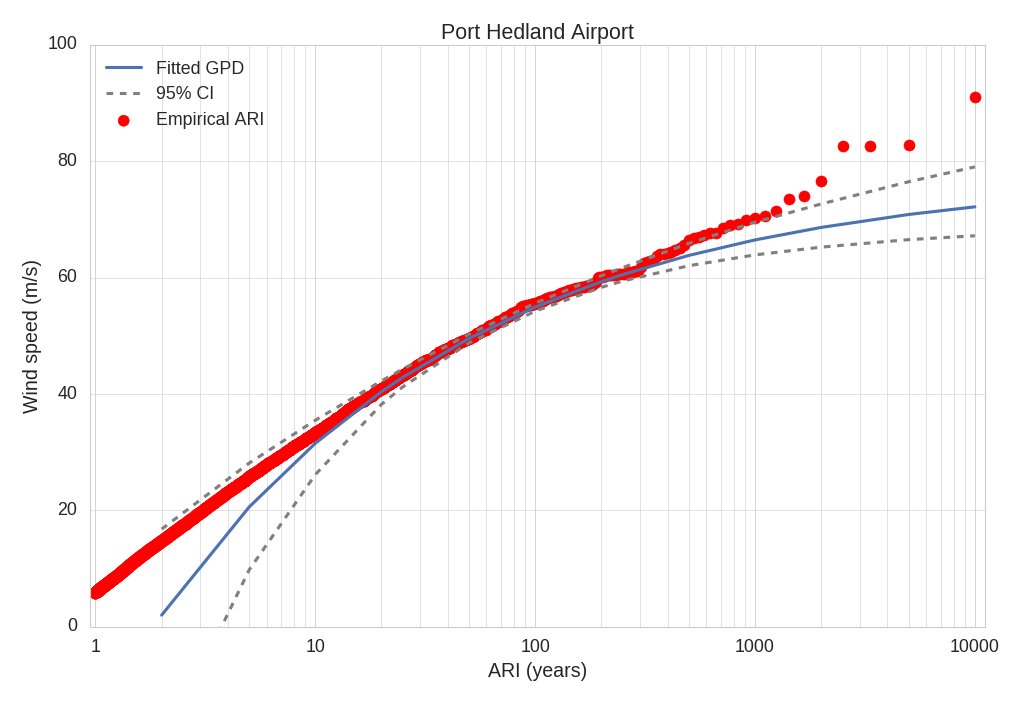

Broome Airport
Number of records > 0: 17429
47.3224511719
(-0.1363529769580599, 47.32572173868472, 6.2316644082354298)
No. exceedances: 175
Rate (calcUncertainty): 4.79123887748e-05
[ 10.27448947  24.09193777  32.3538109   39.10796884  41.00831457
  46.18310588  50.41354578  53.87196965  54.84502966  57.49474883
  59.66091884  61.43178291  63.28680409  64.39597775]


<IPython.core.display.Javascript object>


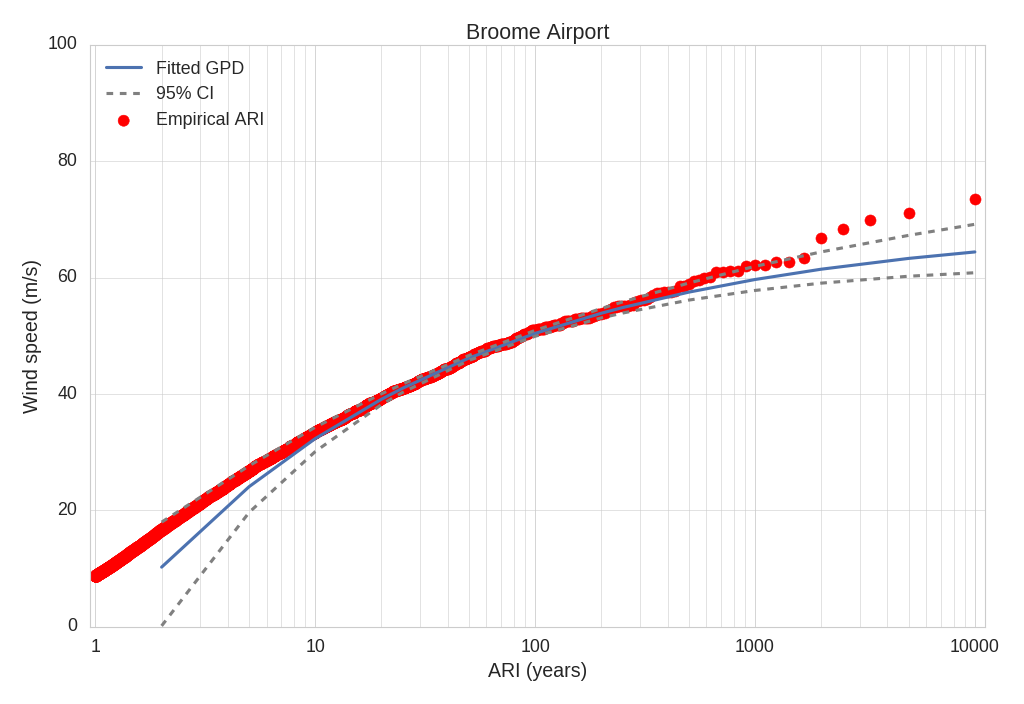

Darwin Airport
Number of records > 0: 19438
36.9401081085
(0.060720263232617144, 36.943199157661326, 4.7981150338604515)
No. exceedances: 195
Rate (calcUncertainty): 5.33880903491e-05
[  3.57001072  15.90710578  23.39216241  29.58778551  31.34567849
  36.17116764  40.16538085  43.47152012  44.40957573  46.98457729
  49.11598924  50.88022775  52.75488282  53.89225749]


<IPython.core.display.Javascript object>


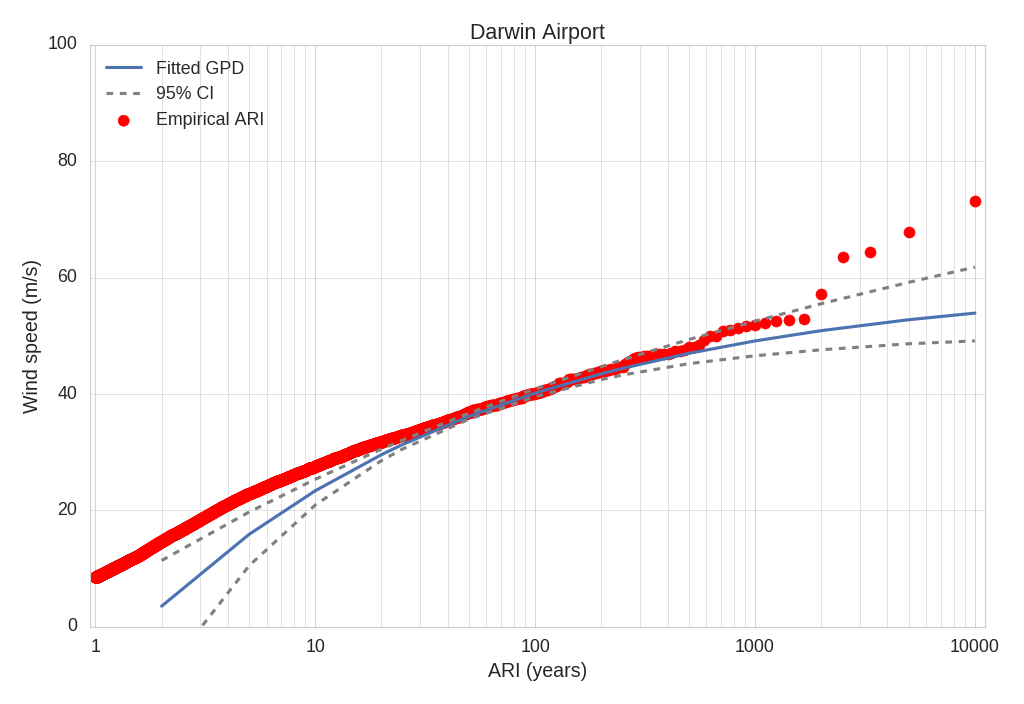

Gove Airport
Number of records > 0: 17969
44.245431366
(-0.10833280111950686, 44.324024199982375, 5.9112980555696799)
No. exceedances: 180
Rate (calcUncertainty): 4.84599589322e-05
[ 25.74707481  30.92048775  34.81210614  38.68494674  39.92774229
  43.775899    47.60548765  51.41659782  52.63958405  56.42640378
  60.1949514   63.94531507  68.87526814  72.58374768]


<IPython.core.display.Javascript object>


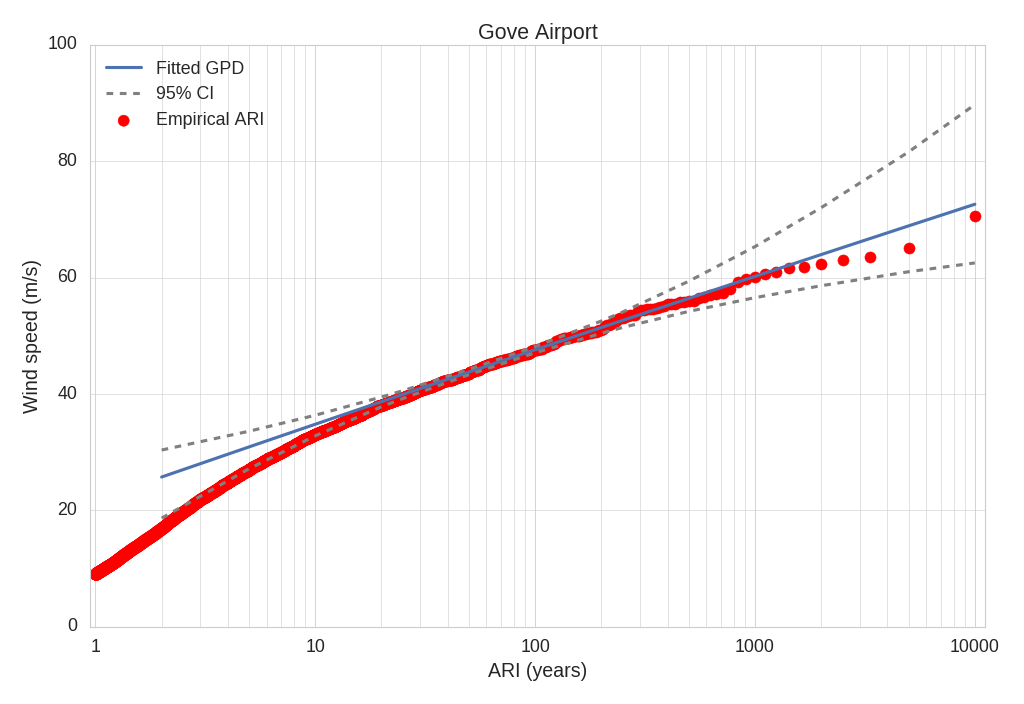

Cairns Airport
Number of records > 0: 18847
42.1254353333
(-0.14562470510756964, 42.133819579909947, 6.9689047117289267)
No. exceedances: 189
Rate (calcUncertainty): 5.17453798768e-05
[  6.62629885  19.10312362  27.05484904  33.91918422  35.92271313
  41.57437705  46.45318176  50.66481496  51.89408606  55.36168121
  58.3550863   60.93914634  63.82092256  65.65753513]


<IPython.core.display.Javascript object>


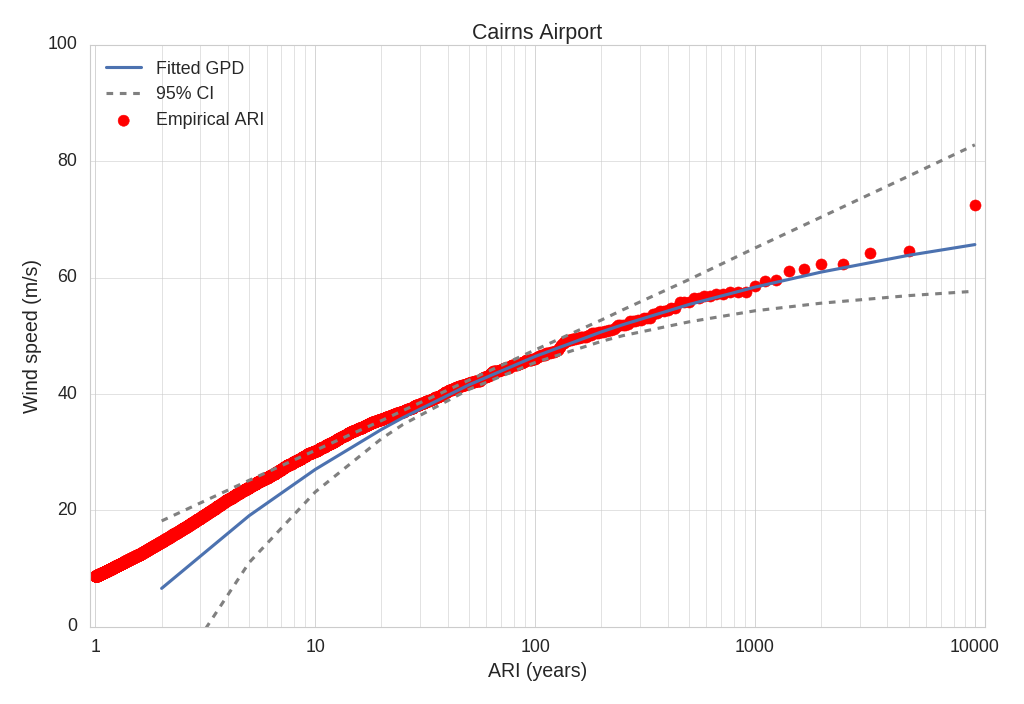

Rockhampton Airport
Number of records > 0: 11529
47.0665052795
(-0.17455951300815473, 47.074001311472188, 9.0970203955160791)
No. exceedances: 116
Rate (calcUncertainty): 3.17590691307e-05
[-21.50341205   1.96816339  16.17675196  27.91520258  31.24147492
  40.36095014  47.89502075  54.11930653  55.8830546   60.71863484
  64.71355803  68.01397089  71.51324918  73.63154779]


<IPython.core.display.Javascript object>


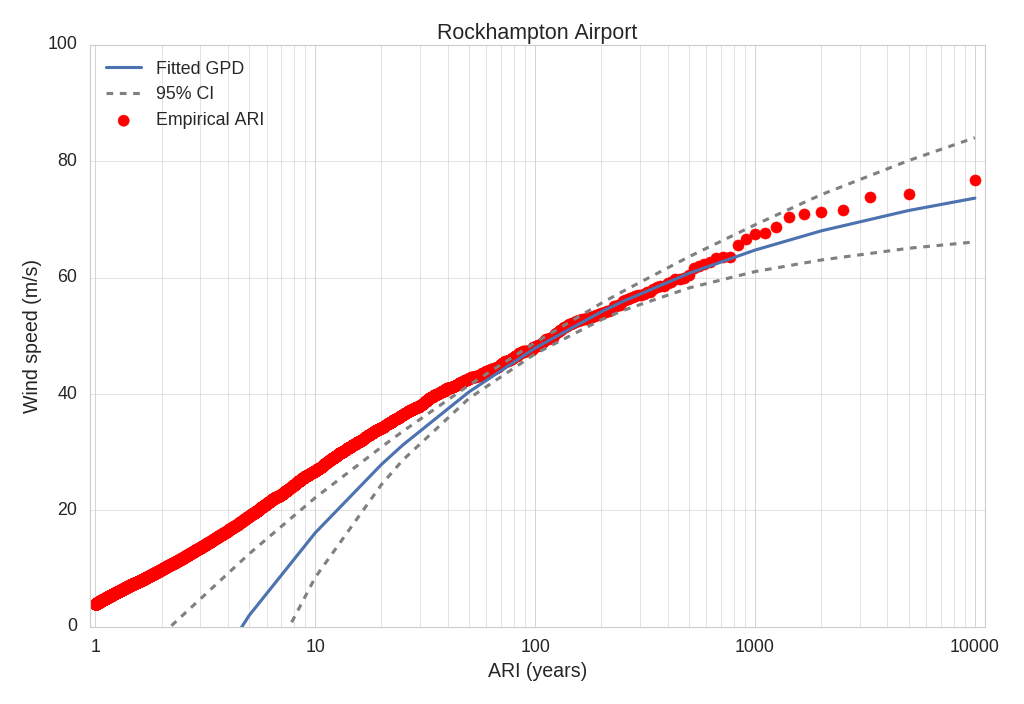

Townsville Amo
Number of records > 0: 16298
44.0313559341
(-0.086058781827064779, 44.054145806689206, 6.0909178835356474)
No. exceedances: 163
Rate (calcUncertainty): 4.46269678303e-05
[-12.58634306   9.98861763  22.52140322  32.14020203  34.73308022
  41.51255291  46.71573647  50.70913246  51.78560672  54.6002117
  56.76039539  58.41831671  60.03375961  60.93059393]


<IPython.core.display.Javascript object>


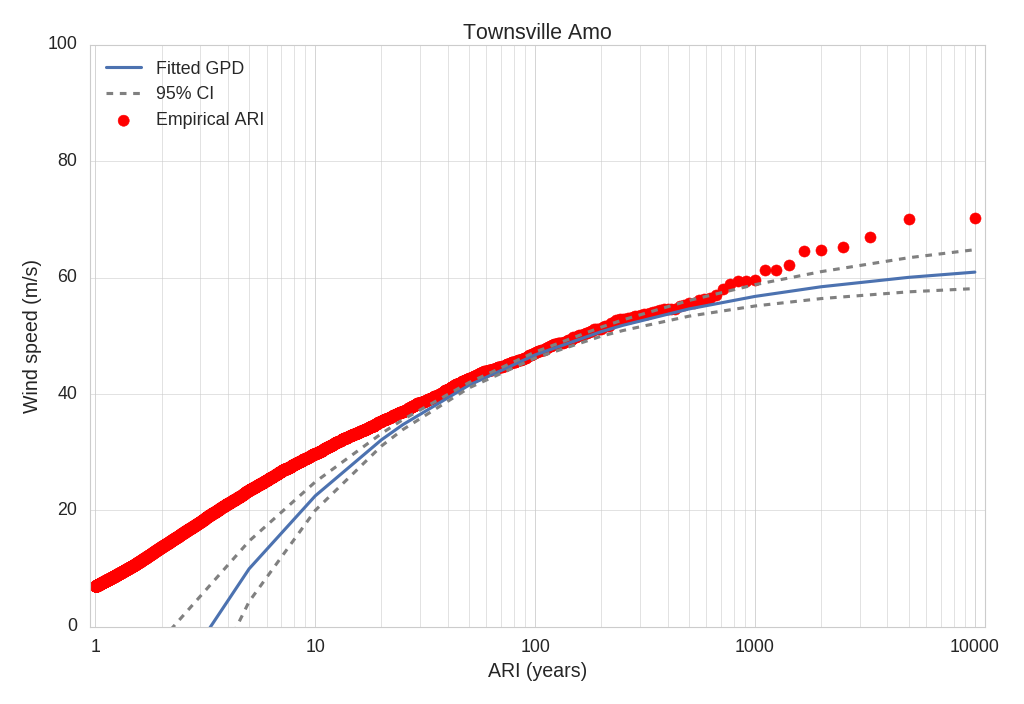

Brisbane Airport M. O
Number of records > 0: 6904
50.1603474426
(-0.088538221201651418, 50.163253679742539, 6.950826751511368)
No. exceedances: 70
Rate (calcUncertainty): 1.72484599589e-05
[ -0.20166865  15.07155122  24.68929057  32.90707189  35.28915079
  41.96401657  47.66728897  52.54039309  53.95295423  57.91111699
  61.29312963  64.18285654  67.36766955  69.3731865 ]


<IPython.core.display.Javascript object>


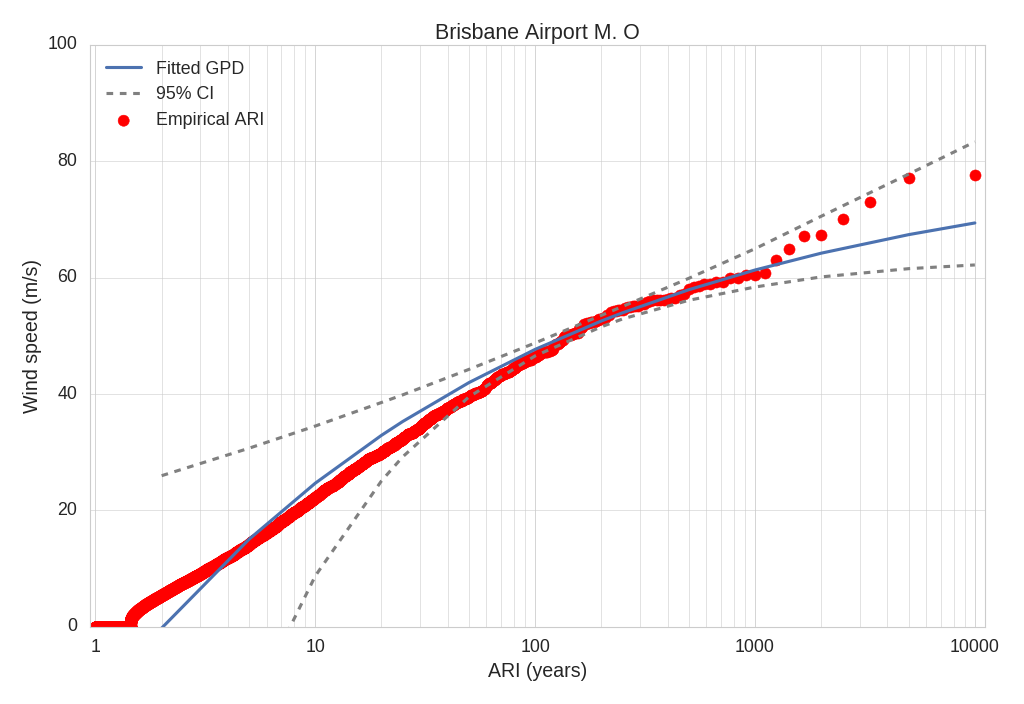

In [26]:
locList = ['Carnarvon Airport','Learmonth Airport', 'Onslow', 'Port Hedland Airport', 'Broome Airport',
           'Darwin Airport', 'Gove Airport', 'Cairns Airport', 'Rockhampton Airport',
           'Townsville Amo', 'Brisbane Airport M. O']

for loc in locList:
    print(loc)
    processCI(loc, 99.)

In [ ]:
#from scipy.interpolate import interp1d
#f = interp1d(emprp[emprp > 1], data[emprp > 1])
#yinterp = f(years)
#plt.plot(years, yinterp)

from scipy.optimize import curve_fit

def residual2(p, x, y):
    f = p['a'] - p['b'] * np.power(x, -0.1)
    return f - y

locName = "Darwin Airport"
locId = locations['locId'][locations['locName']==locName][0]
events = extractRecords(db, locId, NumSimulations)
emprp = empReturnPeriod(events)

In [ ]:
pars,cov = curve_fit(lambda x, a, b: a - b * np.power(x, -0.1), 
                     events, emprp, p0=[np.max(events), np.mean(events)], maxfev=10000 )
pars

In [ ]:
p2 = lmfit.Parameters()
p2.add_many(('a', pars[0], True, 0, np.inf), ('b', pars[1]))

mini2 = lmfit.Minimizer(residual2, p2, fcn_args=(events, emprp), nan_policy='omit')

    # first solve with Nelder-Mead
out21 = mini2.minimize(method='Nelder')
out22 = mini2.minimize(method='leastsq', params=out21.params)


In [ ]:
out22.params